In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from river import linear_model,stream, evaluate, metrics, preprocessing, optim, time_series
from statsmodels.tsa.arima.model import ARIMA
df = pd.read_csv("../data/simulations/900/sim_df.csv")
df_meta = pd.read_csv("../data/simulations/900/meta.csv")
print(df.head(1))
print(df_meta.head(1))

        V1  t
0  1.25429  1
    ar1  ar2  ar3  ar4  ma1  ma2  ma3    sigma2  start_date  order    end_date
0  0.66    0    0    0    0    0    0  1.165425  2013-09-11      0  2013-10-22


In [2]:
def aplicar_drift(df, coluna='V1', tipo='abrupto', pontos_drift=None, aleatorio=False, num_pontos=1, duracao_drift=None, **kwargs):
    """
    Aplica drift a uma coluna de um DataFrame.

    Parâmetros:
    - df: DataFrame contendo a série temporal.
    - coluna: Nome da coluna a ser modificada.
    - tipo: Tipo de drift a ser aplicado ('abrupto', 'gradual', 'incremental', 'recorrente').
    - pontos_drift: Lista de pontos (t) onde o drift deve ser aplicado. Ignorado se aleatorio=True e para drift incremental com duração definida.
    - aleatorio: Se True, escolhe pontos de drift aleatórios. Para drift incremental, define início e término aleatoriamente com base na duração.
    - num_pontos: Número de pontos de drift a serem escolhidos aleatoriamente. Ignorado se aleatorio=False.
    - duracao_drift: Duração do drift incremental. Usado apenas para o tipo 'incremental' se aleatorio=True.
    - **kwargs: Argumentos adicionais específicos para cada tipo de drift.
    """
    n = len(df)
    if aleatorio and tipo != 'incremental':
        pontos_drift = np.sort(np.random.choice(df.index, num_pontos, replace=False))
    elif aleatorio and tipo == 'incremental' and duracao_drift is not None:
        inicio_drift = np.random.randint(0, n - duracao_drift)
        termino_drift = inicio_drift + duracao_drift
        pontos_drift = [inicio_drift, termino_drift]
    elif pontos_drift is None:
        pontos_drift = [n // 2]  # Ponto médio se nenhum ponto for fornecido e aleatorio=False
    
    if tipo == 'abrupto':
        delta = kwargs.get('delta', np.random.normal(10, 1))  # Default: distribuição normal N(10, 1)
        for ponto in pontos_drift:
            df.loc[df.index >= ponto, coluna] += delta

    elif tipo == 'gradual':
        incremento_por_passo = kwargs.get('incremento_por_passo', 0.1)
        for ponto in pontos_drift:
            df.loc[df.index >= ponto, coluna] += incremento_por_passo * (df.loc[df.index >= ponto, 't'] - ponto)

    elif tipo == 'incremental':
        if duracao_drift is None:
            duracao_drift = np.random.randint(50, 150) 
        if aleatorio:
            inicio_drift = np.random.randint(0, n - duracao_drift)
            termino_drift = inicio_drift + duracao_drift
            print(inicio_drift)
            print(termino_drift)
        else:
            inicio_drift = kwargs.get('inicio_drift', 0)
            termino_drift = kwargs.get('termino_drift', inicio_drift + duracao_drift)
        
        incremento_base = kwargs.get('incremento', np.random.normal(0.1, 0.05))
        variancia_base = kwargs.get('variancia', 0.02)
        amplitude_variacao = kwargs.get('amplitude_variacao', 0.05)  # Amplitude da variação no incremento
        frequencia_variacao = kwargs.get('frequencia_variacao', np.pi/(termino_drift - inicio_drift))  # Define a frequência da variação sinusoidal

        for i in range(inicio_drift, termino_drift + 1):
            # Calcula um incremento que varia ao longo do tempo, adicionando uma componente sinusoidal
            variacao_sinusoidal = amplitude_variacao * np.sin(frequencia_variacao * (i - inicio_drift))
            incremento_atual = incremento_base + variacao_sinusoidal + np.random.normal(0, variancia_base)
            
            # Aplica o incremento, ajustando pela distância do início do drift
            df.loc[i, coluna] += (i - inicio_drift) * incremento_atual
        
        # Calcula o aumento a ser aplicado aos valores após o término do drift
        aumento = df.loc[termino_drift, coluna]
        print(aumento)
        
        # Aplica o aumento aos valores restantes da série
        for i in range(termino_drift + 1, n):
            df.loc[i, coluna] += aumento

    elif tipo == 'recorrente':
        # Gera um período aleatório entre 50 e 200. Isso assegura uma variabilidade na frequência das oscilações
        # Menores valores de período gerarão mais oscilações, maiores valores gerarão menos oscilações
        periodo = kwargs.get('periodo', np.random.randint(50, 201))

        # Gera uma amplitude aleatória entre 3 e 10. Isso assegura variabilidade na intensidade das oscilações
        # Amplitudes maiores farão as oscilações serem mais pronunciadas
        amplitude = kwargs.get('amplitude', np.random.uniform(3, 10))

        for i in range(n):
            df.loc[i, coluna] += amplitude * np.sin(2 * np.pi * df.loc[i, 't'] / periodo)

    else:
        raise ValueError("Tipo de drift não suportado. Escolha entre 'abrupto', 'gradual', 'incremental', 'recorrente'.")

    return df

# Aplicar drift abrupto em pontos aleatórios
df = aplicar_drift(df, tipo='abrupto', aleatorio=True, num_pontos=2, delta=5)

In [3]:
def plot_sequential_data(start=None, end=None, Y_list=[], Y_pred=[], met_list=[], erros = []):
    """
    Plota gráficos sequenciais para as três listas fornecidas.

    Args:
    - start (int, None): Ponto inicial da sequência. Se None, começa do início.
    - end (int, None): Ponto final da sequência. Se None, vai até o final.
    - Y_list (list): Lista com os dados reais.
    - Y_pred (list): Lista com as predições.
    - met_list (list): Lista com as métricas.
    """
    
    # Se start ou end for None, ajustar para os limites das listas
    if start is None:
        start = 0
    if end is None:
        end = len(Y_list)  # Assume-se que todas as listas têm o mesmo comprimento

    erro_medio = np.mean(erros)

    # Restringindo as listas ao intervalo especificado
    Y_list, Y_pred, met_list = Y_list[start:end], Y_pred[start:end], met_list[start:end]
    dif = [a - b for a, b in zip(Y_list, Y_pred)]
    # Gerando o eixo x sequencial
    x = list(range(start, end))

    plt.figure(figsize=(10, 4))
    plt.title(f'Simulado x Predito')
    plt.plot(x, Y_list, label="Simulado", color='black', alpha = .8)
    plt.plot(x, Y_pred, label="Predito", color='blue', alpha = .2)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title(f'RMSE')
    plt.plot(x, met_list, label="Simulado", color='blue')
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title(f'Resíduo')
    plt.plot(x, erros[start:end], label="Simulado", color='blue')
    plt.axhline(y=erro_medio, color='green', linestyle='--', label='Erro Médio')
    plt.show()

In [4]:
X = df[['t']]
y = df.pop('V1')

In [5]:
model = time_series.SNARIMAX(
    p=1,
    d=1,
    q=1,
    regressor=(
        preprocessing.StandardScaler() |
        linear_model.LinearRegression(optimizer=optim.AdaGrad(),intercept_lr=0.1)#.Adam(ok), AMSGrad(top), AdaDelta, AdaGrad(top), 
                                                                               #AdaMax(top),FTRLProximal(top),Momentum(nope),
                                                                               #Nadam, NesterovMomentum(nope), RMSProp (top)
    )
)

metrica = metrics.RMSE()
Y_list = []
Y_real_nowcast = []  # Lista para guardar os valores reais usados para calcular o nowcasting error
Y_pred_list = []
Y_nowcasting_list = []
met_list = []
error_incremental_list = []

for xi, yi in stream.iter_pandas(X, y):
    
    Y_list.append(yi)
    y_pred = model.forecast(horizon=1)
    #print("Real: " + str(yi))
    #print("Predito: " + str(y_pred))
    Y_pred_list.append(y_pred)
    model.learn_one(yi)
    metrica.update(yi, y_pred[-1])
    erro = yi - y_pred[-1]
    y_pred = model.forecast(horizon=1)
    #print("Nowcasting: " + str(y_pred))
    Y_nowcasting_list.append(y_pred[-1])
    met_list.append(metrica.get())
    error_incremental_list.append(erro)

print("----------------------------------------------------------------------")

# Inicializações
soma_erros_quadrados = 0  # Soma dos erros quadrados
rmse_incremental = []  # Lista para armazenar o RMSE incremental
Y_real_nowcast = []  # Lista para armazenar os valores reais usados para calcular o erro de nowcasting
nowcasting_error_incremental_list = []  # Lista para armazenar os erros de nowcasting

for i in range(len(Y_list)-1):  # Subtrai 1 porque não há um próximo valor para o último item
    # O valor real para calcular o erro de nowcasting é o próximo valor em Y_list
    valor_real = Y_list[i+1]
    Y_real_nowcast.append(valor_real)  # Guarda o valor real subsequente para calcular o erro de nowcasting
    
    # O erro de nowcasting é a diferença entre o valor real subsequente e a previsão de nowcasting
    nowcasting_error = valor_real - Y_nowcasting_list[i]
    nowcasting_error_incremental_list.append(nowcasting_error)
    
    # Atualiza a soma dos erros quadrados
    soma_erros_quadrados += nowcasting_error ** 2
    
    # Calcula o RMSE incremental
    n = i + 1  # Número de observações até o momento
    rmse_atual = np.sqrt(soma_erros_quadrados / n)
    rmse_incremental.append(rmse_atual)


----------------------------------------------------------------------


In [6]:
print(len(Y_list))
print(len(met_list))
print(len(Y_nowcasting_list))
print(len(Y_real_nowcast))
print(len(nowcasting_error_incremental_list))
print(len(rmse_incremental))

1000
1000
1000
999
999
999


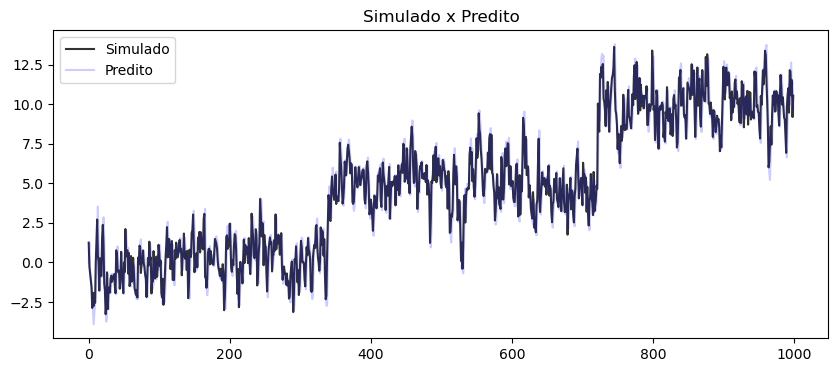

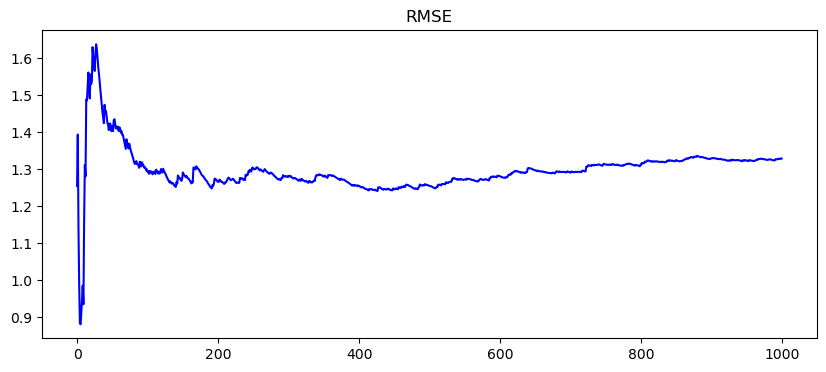

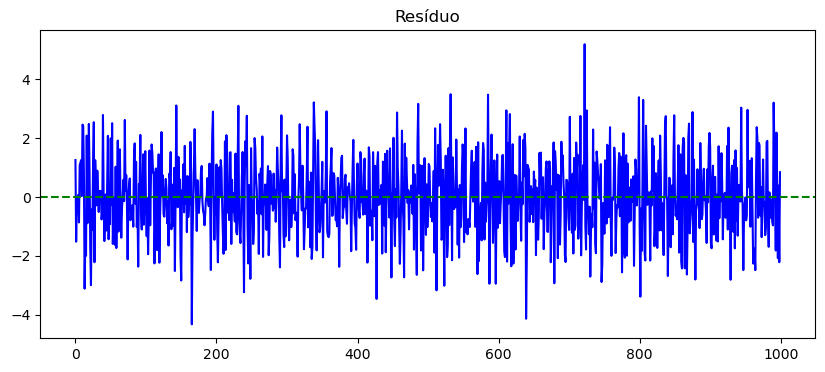

In [7]:
plot_sequential_data(0, len(met_list), Y_list, Y_pred_list, met_list,error_incremental_list)  # Plota toda a série

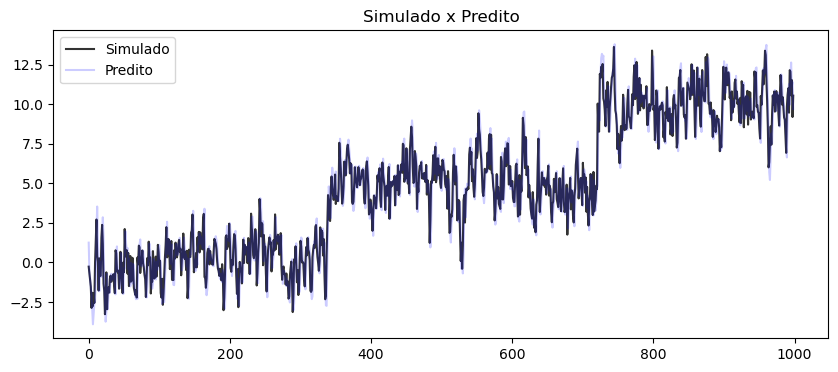

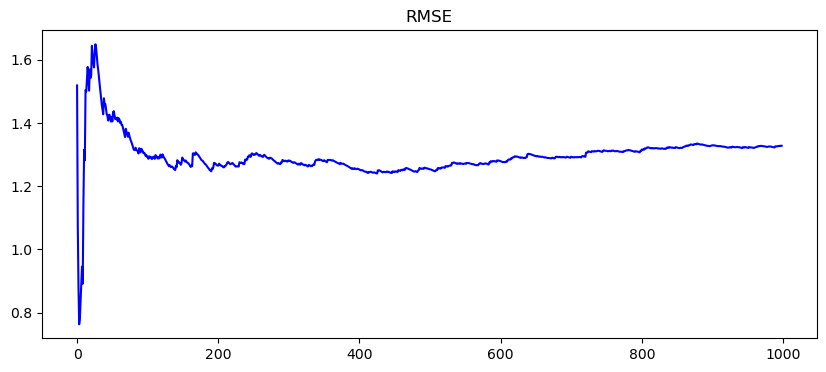

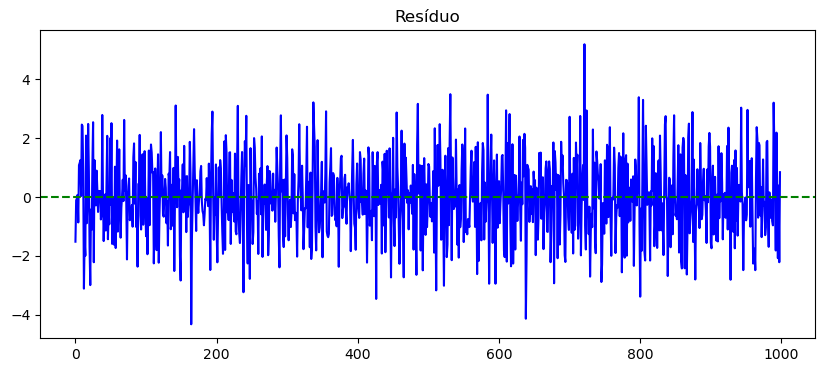

In [8]:
plot_sequential_data(0, len(nowcasting_error_incremental_list), 
                     Y_real_nowcast,
                     Y_nowcasting_list,
                     rmse_incremental,
                     nowcasting_error_incremental_list)  # Plota toda a série

# Arima

In [9]:
df_meta

,ar1,ar2,ar3,ar4,ma1,ma2,ma3,sigma2,start_date,order,end_date
0,0.66,0,0,0,0,0,0,1.165425,2013-09-11,0,2013-10-22


In [10]:
df_meta_long = (pd.wide_to_long(df_meta[["ar1", "ar2", "ar3", "ar4", "ma1", "ma2", "ma3","order"]]
                                .reset_index(), stubnames= ["ar", "ma"], i = "index", j = "params")
                                .reset_index()
                                .drop(columns = ["index"]))
                                #.replace(0, np.nan))
df_meta_long

,params,order,ar,ma
0,1,0,0.66,0.0
1,2,0,0.00,0.0
2,3,0,0.00,0.0
3,4,0,0.00,NaN


In [11]:
p = df_meta_long.query("ar > 0").params.tolist()
d = df_meta_long.iloc[0].order.astype('int')
q = df_meta_long.query("ma > 0").params.tolist()
if (len(q) == 0):
    q = 0
print(p)
print(d)
print(q)

[1]
0
0


In [12]:
# Configurações iniciais
X = 1  # Ajustar o modelo a cada X observações
n = len(y)  # Total de pontos de dados
min_obs_for_arima = 2  # Número mínimo de observações para ajustar ARIMA; ajuste conforme necessário

# Arrays para armazenar previsões e erros
arima_nowcasting_predictions = []
arima_nowcasting_error_list = []
rmse_at_each_step = []  # Lista para armazenar o RMSE a cada passo
y_real_nowcasting_arima = []

# Loop para ajustar o ARIMA e fazer previsões nowcasting
for i in range(n - 1):
    if i >= min_obs_for_arima and i % X == 0:
        try:
            model_arima = ARIMA(y[:i+1], order=(p,d,q))
            model_arima_fit = model_arima.fit()
        except ValueError as e:
            print(f"Erro ao ajustar o ARIMA na iteração {i}: {e}")
            continue
    else:
        first_forecast_value = 0
        arima_nowcasting_predictions.append(first_forecast_value)
        actual_value = y.iloc[i+1]
        error = actual_value - first_forecast_value
        arima_nowcasting_error_list.append(error)
        y_real_nowcasting_arima.append(actual_value)
        current_rmse = np.sqrt(np.mean(np.square(arima_nowcasting_error_list)))
        rmse_at_each_step.append(current_rmse)


    if 'model_arima_fit' in locals():
        forecast = model_arima_fit.forecast(steps=1)
        first_forecast_value = forecast.iloc[0]

        arima_nowcasting_predictions.append(first_forecast_value)

        actual_value = y.iloc[i+1]
        error = actual_value - first_forecast_value
        arima_nowcasting_error_list.append(error)
        y_real_nowcasting_arima.append(actual_value)

        # Atualizar RMSE a cada passo
        current_rmse = np.sqrt(np.mean(np.square(arima_nowcasting_error_list)))
        rmse_at_each_step.append(current_rmse)

# Se desejar imprimir ou analisar o RMSE final global
if arima_nowcasting_error_list:
    global_rmse_arima = np.sqrt(np.mean(np.square(arima_nowcasting_error_list)))
    print(f"RMSE ARIMA Nowcasting global: {global_rmse_arima}")
else:
    print("Não foi possível calcular o RMSE ARIMA devido à falta de previsões.")

RMSE ARIMA Nowcasting global: 1.2349820691563365


In [13]:
print(len(y_real_nowcasting_arima))
print(len(arima_nowcasting_predictions))
print(len(rmse_at_each_step))
print(len(arima_nowcasting_error_list))

999
999
999
999


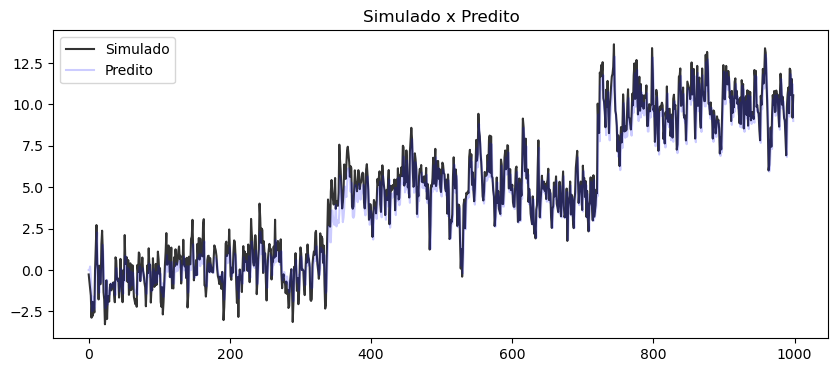

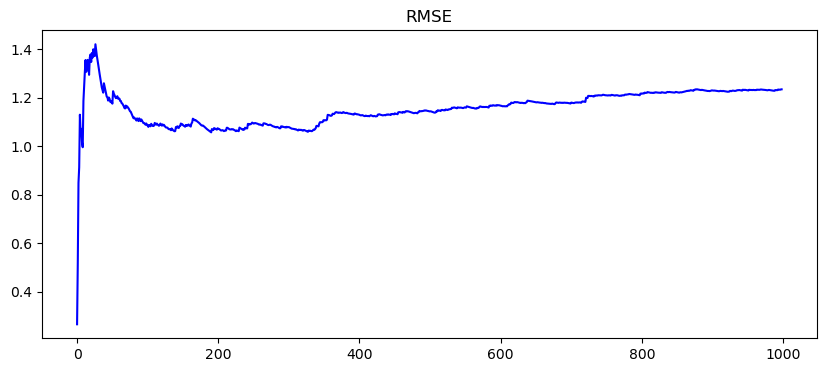

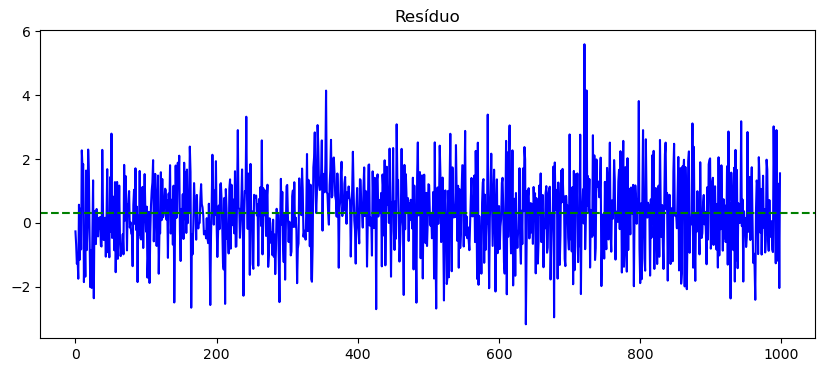

In [14]:
plot_sequential_data(0, len(rmse_at_each_step),
                     y_real_nowcasting_arima,
                     arima_nowcasting_predictions,
                     rmse_at_each_step,
                     arima_nowcasting_error_list)  # Plota toda a série

Arima x Arima Incremental

In [15]:
len(Y_nowcasting_list[0:-1])

999

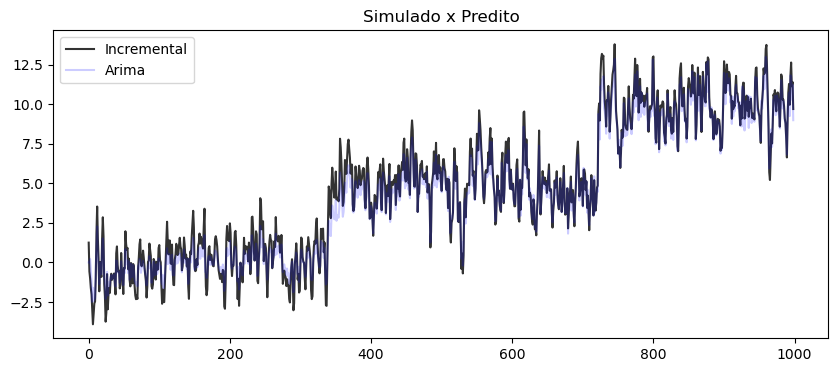

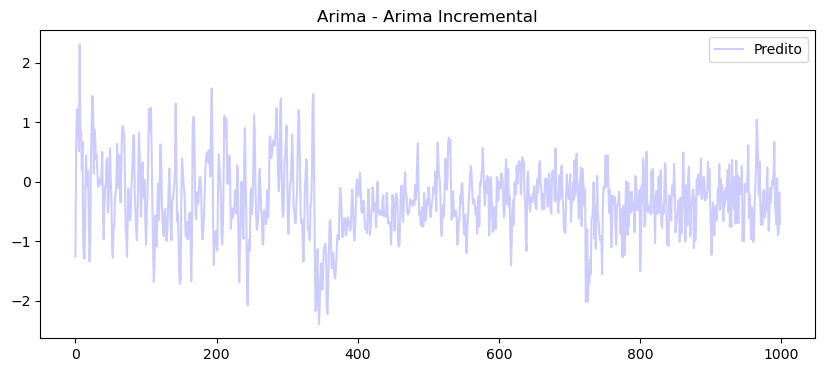

In [16]:
arima_nowcasting = arima_nowcasting_predictions
arima_incr_nowcasting = Y_nowcasting_list[0:-1]

x_plot = list(range(0, len(arima_nowcasting)))
dif_models = [a - b for a, b in zip(arima_nowcasting_predictions, arima_incr_nowcasting)]

plt.figure(figsize=(10, 4))
plt.title(f'Simulado x Predito')
plt.plot(x_plot, arima_incr_nowcasting, label="Incremental", color='black', alpha = .8)
plt.plot(x_plot, arima_nowcasting, label="Arima", color='blue', alpha = .2)
plt.legend()

plt.figure(figsize=(10, 4))
plt.title(f'Arima - Arima Incremental')
plt.plot(x_plot, dif_models, label="Predito", color='blue', alpha = .2)
plt.legend()
plt.show()

# Regret

In [17]:
def calcular_regret(arima_nowcasting_error_list, nowcasting_error_incremental_list):
    # Assegura que ambas as listas têm o mesmo tamanho
    if len(arima_nowcasting_error_list) != len(nowcasting_error_incremental_list):
        raise ValueError("As listas devem ter o mesmo tamanho.")
    
    # Calcula o regret acumulado
    regret_acumulado = 0
    regrets = []  # Para armazenar o regret a cada passo
    for arima_error, incr_error in zip(arima_nowcasting_error_list, nowcasting_error_incremental_list):
        regret_acumulado += abs(incr_error - arima_error)
        regrets.append(regret_acumulado)
    
    return regrets

regrets = calcular_regret(arima_nowcasting_error_list, nowcasting_error_incremental_list)
len(regrets)

999

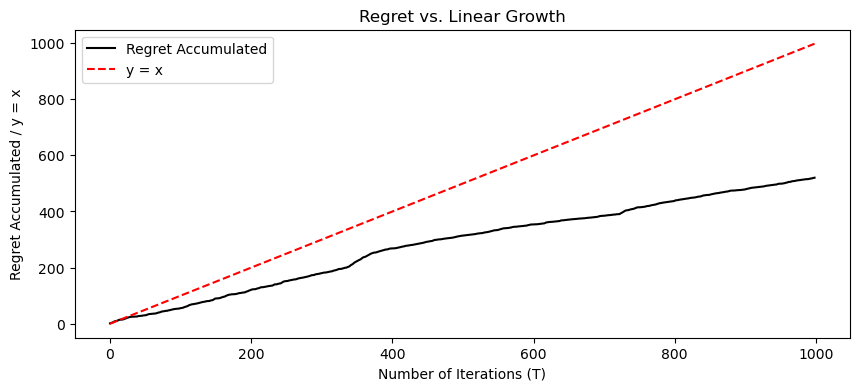

In [18]:
plt.figure(figsize=(10, 4))
plt.title('Regret vs. Linear Growth')

# Plota o regret acumulado
plt.plot(x_plot, regrets, label='Regret Accumulated', color='black')

# Plota uma linha y = x para comparação
plt.plot(x_plot, x_plot, label='y = x', color='red', linestyle='--')

plt.xlabel('Number of Iterations (T)')
plt.ylabel('Regret Accumulated / y = x')
plt.legend()
plt.show()

In [19]:
coef_angular, coef_linear = np.polyfit(x_plot, regrets, 1)

print(f"Coeficiente angular: {coef_angular}")

Coeficiente angular: 0.5223263788431705
